In [28]:
#pip install langchain_community
#pip uninstall pandas


## Importação de bibliotecas e inicialização de variáveis

In [46]:
from langchain_community.llms import Ollama
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import streamlit as st

In [30]:
llm = Ollama(model="llama3")

## Ingestão de dados

In [31]:
#Função para ler o arquivo JSON REFERENCIA
file_path = "cadastro.json"
def read_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [41]:
# Função para ler o arquivo JSON REAL
def read_json(file_path):
    with open(file_path, 'r') as f:
        data_real = json.load(f)
    return data_real

# Carregar o JSON de referência a partir do arquivo externo
reference_json = read_json('cadastro_interacao.json')

## Comparação dos dados

In [42]:
 #Função para comparar o JSON de interações atual com o JSON de referência
def compare_json(current_json, reference_json):
    insights = []
    
    # Convertendo para DataFrames para facilitar a comparação
    df_current = pd.DataFrame(current_json['flow'])
    df_reference = pd.DataFrame(reference_json['flow'])
    
    # Verificar diferenças no número de etapas
    if len(df_current) != len(df_reference):
        insights.append(f"Different number of steps: Current flow has {len(df_current)} steps, while reference has {len(df_reference)}.")
    
    
    
    # Comparar cada etapa (por exemplo, tempo gasto, cliques)
    for i, row in df_current.iterrows():
        if i < len(df_reference):
            ref_row = df_reference.iloc[i]
            
            # Comparar a duração de cada etapa
            if row['duration_seconds'] > ref_row['duration_seconds']:
                insights.append(f"Step {i+1}: User spent {row['duration_seconds']}s on '{row['step']}', which is longer than the reference time of {ref_row['duration_seconds']}s.")
            elif row['duration_seconds'] < ref_row['duration_seconds']:
                insights.append(f"Step {i+1}: User spent {row['duration_seconds']}s on '{row['step']}', which is shorter than the reference time of {ref_row['duration_seconds']}s.")
            
            # Comparar a quantidade de cliques
            if row['clicks'] != ref_row['clicks']:
                insights.append(f"Step {i+1}: User clicked {row['clicks']} times, expected {ref_row['clicks']} clicks.")
            
            # Comparar os campos preenchidos
            if 'input_fields' in row and 'input_fields' in ref_row:
                if row['input_fields'] != ref_row['input_fields']:
                    insights.append(f"Step {i+1}: Input fields mismatch. Current inputs are {row['input_fields']}, expected {ref_row['input_fields']}.")
        else:
            insights.append(f"Step {i+1}: No corresponding step in the reference flow.")

            if row['session_order'] != ref_row['session_order']:
                insights.append(f"Step {i+1}: User followed a different flow order.")
    
    return insights

In [43]:
#Ler o JSON de interações atual
current_json = read_json('cadastro.json') 

## Geração de insights

In [44]:
#Comparar e gerar insights
insights = compare_json(current_json, reference_json)


In [36]:
# # Função para chamar o Llama3 com insights e perguntas adicionais
# def ask_llama_for_insights(insights):
#     # Montar a mensagem a ser enviada para o Llama3
#     insight_message = "Aqui estão os insights gerados a partir da comparação dos JSONs:\n\n"
#     insight_message += "\n".join(insights)
    
#     # Chamar o Llama3 com a mensagem de insights
#     response = llm.invoke(insight_message)
    
#     # Exibir a resposta gerada pela IA
#     return response
# # 
# # Obter insights da IA Llama3
# response = ask_llama_for_insights(insights)
# print(response)

Based on the insights generated from comparing the JSONs, here are some observations and potential issues:

**Step 2:**

* The user spent less time (100s) than expected (120s) filling out personal data.
* There was a mismatch in input fields. The current inputs did not match the expected values:
	+ Expected: {'nome': 'João da Silva', 'email': 'joao.silva@empresa.com', 'telefone': '123456789'}
	+ Actual: {'nome': 'Ana Costa', 'email': 'ana.costa@empresa.com', 'telefone': '123987456'}

**Step 3:**

* The user spent less time (80s) than expected (300s) confirming registration data.

**Step 4:**

* The user spent more time (500s) than expected (15s) completing the registration.
* The user clicked 6 times, which is significantly higher than the expected number of clicks (1).

These insights suggest that there may be issues with the user's experience and behavior during the registration process. Specifically:

* The mismatch in input fields in Step 2 could indicate a problem with data valida

In [45]:
# Exibir insights gerados
for insight in insights:
    print(insight)

Step 2: User spent 100s on 'Preencher dados pessoais', which is shorter than the reference time of 120s.
Step 2: Input fields mismatch. Current inputs are [{'field': 'nome', 'value': 'Ana Costa'}, {'field': 'email', 'value': 'ana.costa@empresa.com'}, {'field': 'telefone', 'value': '123987456'}], expected [{'field': 'nome', 'value': 'João da Silva'}, {'field': 'email', 'value': 'joao.silva@empresa.com'}, {'field': 'telefone', 'value': '123456789'}].
Step 3: User spent 80s on 'Confirmar dados de cadastramento', which is shorter than the reference time of 300s.
Step 4: User spent 500s on 'Finalizar cadastro', which is longer than the reference time of 15s.
Step 4: User clicked 6 times, expected 1 clicks.


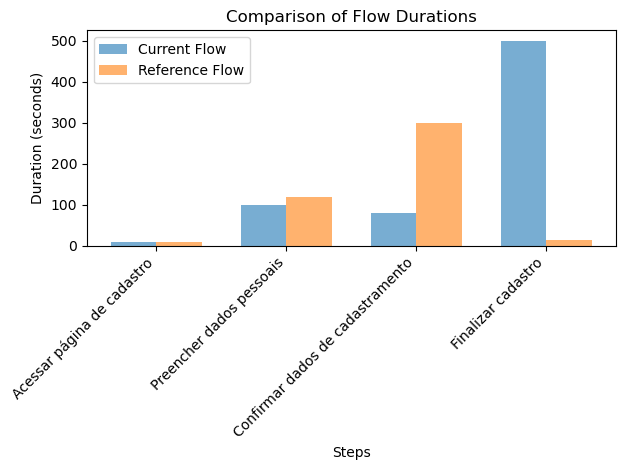

In [40]:

# Função para plotar a comparação entre os tempos dos fluxos
def plot_comparison(current_json, reference_json):
    steps = [step['step'] for step in current_json['flow']]
    current_durations = [step['duration_seconds'] for step in current_json['flow']]
    reference_durations = [step['duration_seconds'] for step in reference_json['flow']]

    # Definir a posição das barras
    x = np.arange(len(steps))  # Localização dos rótulos no eixo x
    width = 0.35  # Largura das barras

    # Criar o gráfico de barras com deslocamento
    fig, ax = plt.subplots()
    bars1 = ax.bar(x - width/2, current_durations, width, label='Current Flow', alpha=0.6)
    bars2 = ax.bar(x + width/2, reference_durations, width, label='Reference Flow', alpha=0.6)

    # Adicionar rótulos e título
    ax.set_xlabel('Steps')
    ax.set_ylabel('Duration (seconds)')
    ax.set_title('Comparison of Flow Durations')
    ax.set_xticks(x)
    ax.set_xticklabels(steps, rotation=45, ha='right')
    ax.legend()

    # Mostrar o gráfico
    plt.tight_layout()
    plt.show()

# Testando a função com os JSONs
plot_comparison(current_json, reference_json)


In [47]:
def show_insights(insights):
    st.title('Insights Comparativos')
    for insight in insights:
        st.write(insight)

if __name__ == '__main__':
    insights = compare_json(current_json, reference_json)
    show_insights(insights)

2024-09-11 16:34:55.149 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-11 16:34:55.224 
  command:

    streamlit run /opt/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-09-11 16:34:55.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-11 16:34:55.225 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-11 16:34:55.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-11 16:34:55.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-11 16:34:55.226 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-09-11 16:34:55.227 Thread 'MainThread': m